Post answers here: https://courses.datatalks.club/sma-zoomcamp-2024/homework/hw02

### Question 1: IPO Filings Web Scraping and Data Processing

**What's the total sum ($m) of 2023 filings that happened on Fridays?**

* Re-use the [Code Snippet 1] example to get the data from web for this endpoint: https://stockanalysis.com/ipos/filings/
* Convert the 'Filing Date' to datetime(), 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs).
* Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given).
* You may be inspired by the function `extract_numbers()` in [Code Snippet 4], or you can write your own function to "parse" a string.
* Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)

* Find the total sum in $m (millions of USD, closest INTEGER number) for all filings during 2023, which happened on Fridays (`Date.dt.dayofweek()==4`). You should see 32 records in total, 25 of it is not null.

(additional: you can read about [S-1 IPO filing](https://www.dfinsolutions.com/knowledge-hub/thought-leadership/knowledge-resources/what-s-1-ipo-filing) to understand the context)

In [2]:
import numpy as np
import pandas as pd

import yfinance as yf
import pandas_datareader as pdr

import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date, datetime, timedelta
import requests
import io

import matplotlib.pyplot as plt

In [2]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/filings/"
response = requests.get(url, headers=headers)

ipos = pd.read_html(io.StringIO(response.text))
ipo_df = ipos[0]
ipo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Filing Date     326 non-null    object
 1   Symbol          326 non-null    object
 2   Company Name    326 non-null    object
 3   Price Range     326 non-null    object
 4   Shares Offered  326 non-null    object
dtypes: object(5)
memory usage: 12.9+ KB


In [3]:
ipo_df['Filing Date'] = pd.to_datetime(ipo_df['Filing Date'], format='mixed')

In [4]:
ipo_df['Shares Offered'] = pd.to_numeric(ipo_df['Shares Offered'], errors='coerce')

<Axes: >

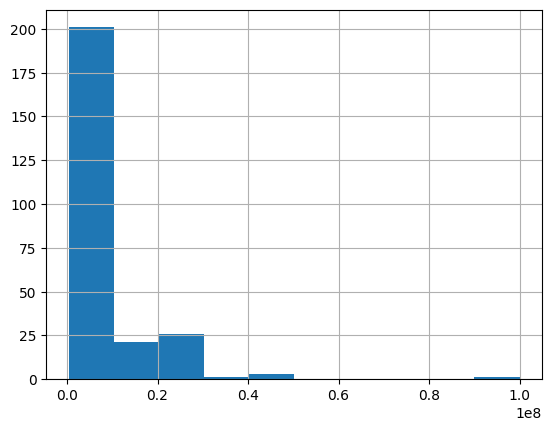

In [5]:
ipo_df['Shares Offered'].hist()

In [6]:
def calculate_average_price(price_range: str) -> float:
    if price_range == '-':
        return np.nan
    if not ('-' in price_range):
        return float(price_range.replace('$', ''))
    
    price_array = price_range.replace('$', '').replace(' ', '').split('-')
    price_array = [float(_price) for _price in price_array]
    return np.mean(price_array)
    
ipo_df['Avg_price'] = ipo_df['Price Range'].apply(calculate_average_price)

<Axes: >

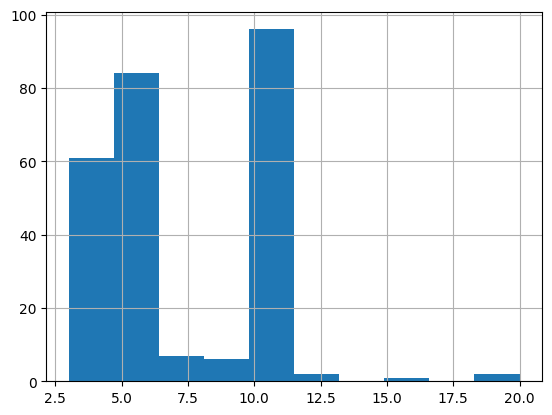

In [7]:
ipo_df['Avg_price'].hist()

In [8]:
ipo_df['Shares_offered_value'] = ipo_df['Shares Offered']*ipo_df['Avg_price']

<Axes: >

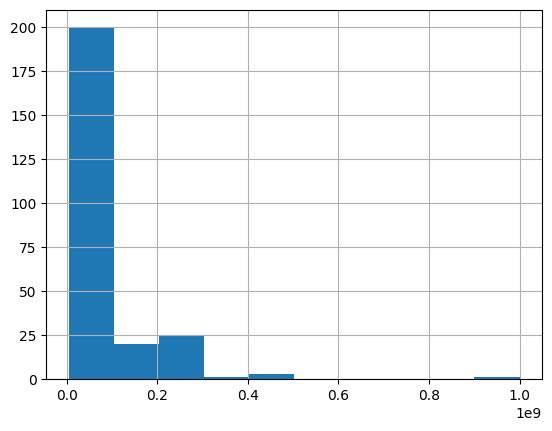

In [9]:
ipo_df['Shares_offered_value'].hist()

In [10]:
len(ipo_df[(ipo_df['Filing Date'].dt.dayofweek==4) &(ipo_df['Filing Date'].dt.year==2023)]['Shares_offered_value'])

32

In [11]:
ipo_df[(ipo_df['Filing Date'].dt.dayofweek==4) &(ipo_df['Filing Date'].dt.year==2023)]['Shares_offered_value'].isna().sum()

7

In [12]:
int(ipo_df[(ipo_df['Filing Date'].dt.dayofweek==4) &(ipo_df['Filing Date'].dt.year==2023)]['Shares_offered_value'].sum()/10**6)

285

### Question 2:  IPOs "Fixed days hold" strategy


**Find the optimal number of days X (between 1 and 30), where 75% quantile growth is the highest?**


* Reuse [Code Snippet 1] to retrieve the list of IPOs from 2023 and 2024 (from URLs: https://stockanalysis.com/ipos/2023/ and https://stockanalysis.com/ipos/2024/). 
* Get all OHLCV daily prices for all stocks with an "IPO date" before March 1, 2024 ("< 2024-03-01") - 184 tickers (without 'RYZB'). Please remove 'RYZB', as it is no longer available on Yahoo Finance. 

* Sometimes you may need to adjust the symbol name (e.g., 'IBAC' on stockanalysis.com -> 'IBACU' on Yahoo Finance) to locate OHLCV prices for all stocks. Also, you can see the ticker changes using this [link](https ://stockanalysis.com/actions/changes/).
Some of the tickers (like 'DYCQ' and 'LEGT') were on the market less than 30 days (11 and 21 days, respectively). Let's leave them in the dataset; it just means that you couldn't hold them for more days than they were listed.

Let's assume you managed to buy a new stock (listed on IPO) on the first day at the [Adj Close] price]. Your strategy is to hold for exactly X full days (where X is between 1 and 30) and sell at the "Adj. Close" price in X days (e.g., if X=1, you sell on the next day).
Find X, when the 75% quantile growth (among 185 investments) is the highest. 

HINTs:
* You can generate 30 additional columns: growth_future_1d ... growth_future_30d, join that with the table of min_dates (first day when each stock has data on Yahoo Finance), and perform vector operations on the resulting dataset.
* You can use the `DataFrame.describe()` function to get mean, min, max, 25-50-75% quantiles.


Additional: 
* You can also ensure that the mean and 50th percentile (median) investment returns are negative for most X values, implying a wager for a "lucky" investor who might be in the top 25%.
* What's your recommendation: Do you suggest pursuing this strategy for an optimal X?

In [13]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/"
response = requests.get(url+'2023/', headers=headers)

In [14]:
ipos_2023 = pd.read_html(io.StringIO(response.text))


In [15]:
response = requests.get(url+'2024/', headers=headers)
ipos_2024 = pd.read_html(io.StringIO(response.text))


In [16]:
ipos = pd.concat([ipos_2023[0], ipos_2024[0]], ignore_index=True)

In [17]:
ipos['IPO Date']  = pd.to_datetime(ipos['IPO Date'])
ipos = ipos[ipos['IPO Date']<=datetime(2024, 3, 1)]

In [18]:
ipos  = ipos[ipos.Symbol!='RYZB']
ipos.Symbol.nunique()

184

In [19]:
ipos

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,2023-12-27,IROH,Iron Horse Acquisitions Corp.,$10.00,$10.05,0.50%
1,2023-12-19,LGCB,Linkage Global Inc,$4.00,$3.00,-25.00%
2,2023-12-15,ZKH,ZKH Group Limited,$15.50,$12.60,-18.71%
3,2023-12-15,BAYA,Bayview Acquisition Corp,$10.00,$10.19,1.90%
4,2023-12-14,INHD,Inno Holdings Inc.,$4.00,$0.65,-83.72%
...,...,...,...,...,...,...
213,2024-01-18,PSBD,Palmer Square Capital BDC Inc.,$16.45,$16.66,0.12%
214,2024-01-18,CCTG,CCSC Technology International Holdings Limited,$6.00,$2.32,-61.67%
215,2024-01-12,SYNX,Silynxcom Ltd.,$4.00,$2.91,-30.75%
216,2024-01-11,SDHC,Smith Douglas Homes Corp.,$21.00,$30.36,45.88%


In [20]:
symbols_mapping = dict(zip(ipos.Symbol.unique(), ipos.Symbol.unique()))
symbols_mapping['PTHR'] = 'HOVR'
symbols_mapping['IBAC'] = 'IBACU'

In [21]:
ipo_symbol_data = dict.fromkeys(ipos.Symbol.unique(), None)
bad_symbols = []
for symbol in ipos.Symbol.unique():
    _temp= yf.download(tickers = symbols_mapping[symbol],
                    end=date(2024,3,1),
                    progress=True)
    if len(_temp) ==0:
        bad_symbols.append(symbol)
        print(symbol)
    else: 
        ipo_symbol_data[symbol] = _temp


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

DYCQ


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LEGT']: Exception("%ticker%: Data doesn't exist for startDate = -1407110400, endDate = 1709269200")
[*********************100%%**********************]  1 of 1 completed


LEGT


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['JVSA']: Exception("%ticker%: Data doesn't exist for startDate = -1407110400, endDate = 1709269200")
[*********************100%%**********************]

JVSA


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [22]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in range(1,31):
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Adj Close'] / df['Adj Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [23]:
import warnings
warnings.filterwarnings('ignore')

ipo_symbol_growth_data = dict.fromkeys(ipos.Symbol.unique(), pd.Series())

for symbol, df in ipo_symbol_data.items():
    if df is not None and len(df)>0:
        _df = get_growth_df(df, '')
        _df.dropna(axis=0, inplace=True)
        if len(_df)>0:
            filing_date = _df.index.min()
            ipo_symbol_growth_data[symbol] = _df.loc[filing_date]

In [24]:
data_to_analyze = pd.DataFrame.from_dict(ipo_symbol_growth_data, orient='index') 

In [25]:
growth_quantile = dict.fromkeys(data_to_analyze.columns, None)
for col in data_to_analyze.columns:
    print(f'{col} -- {np.quantile(data_to_analyze[col], 0.75)}')
    growth_quantile[col] = np.quantile(data_to_analyze[col], 0.75)

growth__1d -- 1.022791053123999
growth__2d -- 1.02244751452471
growth__3d -- 1.0428423220403442
growth__4d -- 1.0477434276716453
growth__5d -- 1.0546345309240512
growth__6d -- 1.0647019269341282
growth__7d -- 1.0587261412464133
growth__8d -- 1.0549563870345917
growth__9d -- 1.052013920536301
growth__10d -- 1.0578056196031351
growth__11d -- 1.0680525352838628
growth__12d -- 1.0751798880087322
growth__13d -- 1.0650910486998693
growth__14d -- 1.0595696372965058
growth__15d -- 1.08196834904801
growth__16d -- 1.0804836123894797
growth__17d -- 1.0617810892341464
growth__18d -- 1.0726477241133359
growth__19d -- 1.0880844433857075
growth__20d -- 1.0936726154802636
growth__21d -- 1.1051194021356574
growth__22d -- 1.0994630156029312
growth__23d -- 1.0813167307964462
growth__24d -- 1.1143098699041851
growth__25d -- 1.0939777387727014
growth__26d -- 1.0583620827490028
growth__27d -- 1.0453127499252883
growth__28d -- 1.044627230064016
growth__29d -- 1.0442576605386467
growth__30d -- 1.0206300770268

In [26]:
max(growth_quantile, key=growth_quantile.get)

'growth__24d'

The closes answer is 28.

### Question 3: Is Growth Concentrated in the Largest Stocks?

**Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?**


Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks 
for 10 full years of data (2014-01-01 to 2023-12-31). You'll need to download slightly more data (7 periods before 2014-01-01 to calculate the growth_7d for the first 6 days correctly):

`US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']`

`EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']`

`INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']`

`LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS`
<br/>

Now let's add the top 12-22 stocks (as of end-April 2024):
<br/>

`NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']`

`NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']`

`NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']`

`LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA`

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS (from the actual stats on Yahoo Finance)

Calculate  `growth_7d` for every stock and every day.
Get the average daily `growth_7d` for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:
| Date   |      ticker_category      |  growth_7d |
|----------|:-------------:|------:|
| 2014-01-01 |  LARGE | 1.011684 |
| 2014-01-01 |   LARGEST   |   1.011797 |

On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.

HINT: you can use pandas.pivot_table() to "flatten" the table (LARGE and LARGEST growth_7d as columns)


In [1]:
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

In [3]:
NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']

NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']

NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']

LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

In [9]:
start_date = date(2014, 1, 1) 
start_date -= timedelta(days=7)
end_date =  date(2023, 12, 31)

In [43]:
def calculate_mean_7_day_growth(list_of_stocks, ticker_category):
    tickers = yf.download(list_of_stocks,
                                start=start_date,
                                end=end_date,
                                interval='1d')
    tickers = tickers.swaplevel(0, 1, axis=1)
    growth_tickers = tickers.loc[:, tickers.columns.get_level_values(1)=='Adj Close']/ tickers.loc[:, tickers.columns.get_level_values(1)=='Adj Close'].shift(7)
    growth_tickers.columns = growth_tickers.columns.droplevel(1)
    growth_tickers = growth_tickers[growth_tickers.index >= '2014-01-01']

    growth_tickers['mean'] = growth_tickers.mean(axis=1)
    growth_tickers['ticker_category'] = ticker_category 
    return growth_tickers[['mean', 'ticker_category']]

In [44]:
mean_growth_largest = calculate_mean_7_day_growth(LARGEST_STOCKS, 'LARGEST')

[*********************100%%**********************]  33 of 33 completed


In [45]:
mean_growth_largest

Ticker,mean,ticker_category
Date,,
2014-01-01,NaN,LARGEST
2014-01-02,NaN,LARGEST
2014-01-03,NaN,LARGEST
2014-01-06,0.990353,LARGEST
2014-01-07,0.987984,LARGEST
...,...,...
2023-12-22,1.013788,LARGEST
2023-12-26,1.014900,LARGEST
2023-12-27,1.013800,LARGEST


In [46]:
mean_growth_large = calculate_mean_7_day_growth(LARGE_STOCKS, 'LARGE')

[*********************100%%**********************]  33 of 33 completed


In [47]:
mean_growth_large

Ticker,mean,ticker_category
Date,,
2014-01-01,NaN,LARGE
2014-01-02,NaN,LARGE
2014-01-03,NaN,LARGE
2014-01-06,0.990707,LARGE
2014-01-07,0.990938,LARGE
...,...,...
2023-12-22,1.003809,LARGE
2023-12-26,1.014441,LARGE
2023-12-27,1.003292,LARGE


In [51]:
pd.concat([mean_growth_large.reset_index(), mean_growth_largest.reset_index()]).sort_values(by=['Date'])

Ticker,Date,mean,ticker_category
0,2014-01-01,NaN,LARGE
0,2014-01-01,NaN,LARGEST
1,2014-01-02,NaN,LARGEST
1,2014-01-02,NaN,LARGE
2,2014-01-03,NaN,LARGE
...,...,...,...
2592,2023-12-27,1.003292,LARGE
2593,2023-12-28,1.009875,LARGEST
2593,2023-12-28,1.001857,LARGE
2594,2023-12-29,0.999161,LARGE


In [59]:
print(f"They were larger on {int(round(100*(mean_growth_large['mean']>mean_growth_largest['mean']).sum()/len(mean_growth_largest), 0))} % of days")

They were bigger on 47 % of days
